Isochrone generation took 1.301079 s.
Making photometry for isochrone: log(t) = 6.00  AKs = 0.70  dist = 4500
     Starting at:  2025-01-30 03:45:39.856382   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F162M = 23.11
Starting filter: jwst,F182M   Elapsed time: 0.68 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2344 K  m_jwst_F182M = 23.10
      Time taken: 1.35 seconds
Isochrone generation took 1.173973 s.
Making photometry for isochrone: log(t) = 6.18  AKs = 0.70  dist = 4500
     Starting at:  2025-01-30 03:45:42.394052   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2292 K  m_jwst_F162M = 23.47
Starting filter: jwst,F182M   Elapsed time: 0.65 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2292 K  m_jwst_F182M = 23.49
      Time taken: 1.30 seconds
Isochrone genera

      Time taken: 1.28 seconds
Changing to logg=5.00 for T=  1631 logg=4.04
Isochrone generation took 1.131284 s.
Making photometry for isochrone: log(t) = 6.95  AKs = 0.70  dist = 4500
     Starting at:  2025-01-30 03:46:20.020765   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1631 K  m_jwst_F162M = 26.11
Starting filter: jwst,F182M   Elapsed time: 0.64 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1631 K  m_jwst_F182M = 25.75
      Time taken: 1.29 seconds
Changing to logg=5.00 for T=  1602 logg=4.04
Isochrone generation took 1.143532 s.
Making photometry for isochrone: log(t) = 6.98  AKs = 0.70  dist = 4500
     Starting at:  2025-01-30 03:46:22.464051   Usually takes ~5 minutes
Starting filter: jwst,F162M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  1602 K  m_jwst_F162M = 26.26
Starting filter: jwst,F182M   Elapsed time: 0.63 seconds
Starting

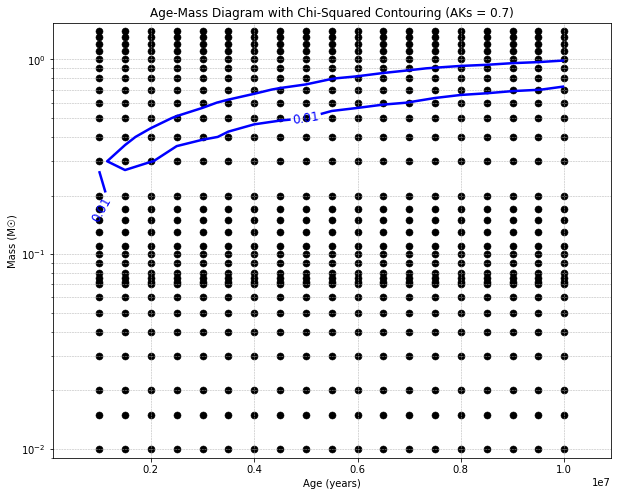

In [27]:
import os
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
from spisea import synthetic, evolution, atmospheres, reddening
from spisea.imf import imf, multiplicity
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import csv

# Paths for isochrones and output
iso_dir = 'isochrones/'
# output_dir = 'output_diagrams/'

# # Ensure output directory exists
# os.makedirs(output_dir, exist_ok=True)

# Estimation variables
star_index = 0      # Set which star in the CSV to analyze

# Define isochrone parameters
dist = 4500
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawCardelli(3.1)
filt_list = ['jwst,F162M', 'jwst,F182M', 'jwst,F200W', 'jwst,356W', 'jwst,F405N']
filters = ['m_jwst_F162M', 'm_jwst_F182M', 'm_jwst_F200W', 'm_jwst_356W', 'm_jwst_F405N']
metallicity = 0
level_ages = np.linspace(1, 10, 19) * 1e6  # Define age array
log_age_arr = np.log10(level_ages)

# Change this as necessary
AKs = 0.7

# Load sample magnitudes, skipping the header row
sample_mags = []
with open('../../s284-no-errors.csv', mode='r') as file:
    csvFile = csv.reader(file)
    next(csvFile)  # Skip header row
    for lines in csvFile:
        sample_mags.append([float(x) for x in lines])

# Chi-square minimization function
def chi_square_reverse_model(iso_grid, sample_mags):
    chi_square_grid = np.zeros((len(iso_grid), len(iso_grid[0].points)))
    for i, iso in enumerate(iso_grid):
        for j, star in enumerate(iso.points):
            chi_square_grid[i, j] = sum(((sample_mags[k] - star[filters[k]]) ** 2) / star[filters[k]] for k in range(len(sample_mags)))
    return chi_square_grid

# Ensure directories exist
os.makedirs(iso_dir, exist_ok=True)
# os.makedirs(output_dir, exist_ok=True)

# Clear previous isochrones
for file in os.listdir(iso_dir):
    os.remove(os.path.join(iso_dir, file))

# Generate isochrone grid
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                            iso_dir=iso_dir)
    for log_age in log_age_arr
])

# Compute chi-square for each point
chi_square_values = chi_square_reverse_model(instances, sample_mags[star_index])

# Extract mass values for each isochrone
masses = np.array([[star['mass'] for star in iso.points] for iso in instances])

# Plot single diagram
fig, ax = plt.subplots(figsize=(10, 8))
norm = LogNorm(vmin=max(np.min(chi_square_values), 1e-3), vmax=np.max(chi_square_values))
cmap = plt.get_cmap('coolwarm')

sc = ax.scatter(
    np.repeat(level_ages, chi_square_values.shape[1]), 
    masses.flatten(), s=50, color='k', edgecolor='k', linewidth=0.5)

# Apply logarithmic scale to y-axis
ax.set_yscale('log')

# Contour plot at chi-square = 0.1
contour = plt.contour(level_ages, masses[0], chi_square_values.T, levels=[0.01], colors=['blue'], linewidths=2.5)
ax.clabel(contour, inline=True, fontsize=12)

# Add labels, grid, and legend
ax.set_xlabel('Age (years)')
ax.set_ylabel('Mass (M☉)')
ax.set_title(f'Age-Mass Diagram with Chi-Squared Contouring (AKs = {AKs})')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adjust grid for log scale

# Add padding to axis limits
x_padding = 0.1 * (level_ages[-1] - level_ages[0])  # 10% padding
y_padding_factor = 0.1  # 10% padding for log scale

ax.set_xlim(level_ages[0] - x_padding, level_ages[-1] + x_padding)
ax.set_ylim(np.min(masses) * (1 - y_padding_factor), np.max(masses) * (1 + y_padding_factor))

plt.show()

# Save the figure
# plt.savefig(os.path.join(output_dir, f'Age_Mass_AKs_{AKs}.png'))
# plt.close()
